#### 5.4.2　可视化卷积神经网络的过滤器
想要观察卷积神经网络学到的过滤器，另一种简单的方法是显示每个过滤器所响应的视觉
模式。这可以通过在输入空间中进行梯度上升来实现：从空白输入图像开始，将梯度下降应用
于卷积神经网络输入图像的值，其目的是让某个过滤器的响应最大化。得到的输入图像是选定
过滤器具有最大响应的图像。

这个过程很简单：我们需要构建一个损失函数，其目的是让某个卷积层的某个过滤器的值最
大化；然后，我们要使用随机梯度下降来调节输入图像的值，以便让这个激活值最大化。例如，
对于在ImageNet 上预训练的VGG16网络，其block3_conv1 层第0 个过滤器激活的损失如下所示。

In [1]:
from keras.applications import VGG16
from keras import backend as K

In [2]:
model = VGG16(weights='imagenet',
             include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, filter_index])

Instructions for updating:
Colocations handled automatically by placer.


为了实现梯度下降，我们需要得到损失相对于模型输入的梯度。为此，我们需要使用Keras
的backend 模块内置的gradients 函数。

In [4]:
#调用gradients 返回的是一个张量列表（本例中列表长度为1）。因此，只保留第一个元素，它是一个张量
grads = K.gradients(loss, model.input)[0]  


为了让梯度下降过程顺利进行，一个非显而易见的技巧是将梯度张量除以其L2 范数（张量
中所有值的平方的平均值的平方根）来标准化。这就确保了输入图像的更新大小始终位于相同
的范围。

In [5]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #做除法前加上1e–5，以防不小心除以0

现在你需要一种方法：给定输入图像，它能够计算损失张量和梯度张量的值。你可以定义
一个Keras 后端函数来实现此方法：iterate 是一个函数，它将一个Numpy 张量（表示为长度
为1 的张量列表）转换为两个Numpy 张量组成的列表，这两个张量分别是损失值和梯度值。

In [7]:
iterate = K.function([model.input],[loss,grads])
import numpy as np

In [8]:
loss_value,grads_value = iterate([np.zeros((1,150,150,3))])

现在你可以定义一个Python 循环来进行随机梯度下降。

In [11]:
input_img_data = np.random.random((1,150,150,3)) * 20 + 128. #从一张带有噪声的灰度图像开始

step = 1.
for i in range(40):# 运行40次梯度上升
    loss_value, grads_value = iterate([input_img_data]) #计算损失值和梯度值
    
    input_img_data += grads_value * step #沿着让损失最大化的方向调节输入图像

得到的图像张量是形状为(1, 150, 150, 3) 的浮点数张量，其取值可能不是[0, 255] 区
间内的整数。因此，你需要对这个张量进行后处理，将其转换为可显示的图像。下面这个简单
的实用函数可以做到这一点。

In [12]:
#将张量转换为有效图像的实用函数
def deprocess_image(x):
    #对张量进行标准化，使其均值为0，标准差为0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    #将x裁切（clip)到[0,1]区间
    x +=0.5
    x = np.clip(x,0,1)
    
    #将x转换为RGB数组
    x = np.clip(x,0,255).astype('uint8')
    return x

接下来，我们将上述代码片段放到一个Python 函数中，输入一个层的名称和一个过滤器索引，
它将返回一个有效的图像张量，表示能够将特定过滤器的激活最大化的模式。

In [32]:

def generate_pattern(layer_name, filter_index, size=150):
    #构建一个损失函数，将该层第N个过滤器的激化最大化
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[: , : , : , filter_index])
    
    grads = K.gradients(loss, model.input)[0]#计算这个损失相对于输入图像的梯度
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #标准化技巧：将梯度标准化
    iterate = K.function([model.input],[loss,grads])#返回给定输入图像的损失和梯度
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128. #从带有噪声的灰度图像开始
    
    setp = 1
    for i in range(40):#运行40次梯度上升
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)


我们来试一下这个函数

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

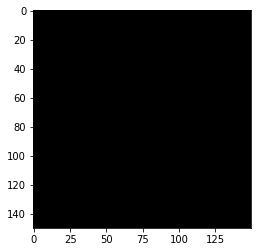

In [23]:
plt.imshow(generate_pattern('block3_conv1',0))

为了简单起见，我们只查看每一
层的前64 个过滤器，并只查看每个卷积块的第一层（即block1_conv1、block2_conv1、
block3_conv1、block4_ conv1、block5_conv1）。我们将输出放在一个8×8 的网格中，
每个网格是一个64 像素×64 像素的过滤器模式，两个过滤器模式之间留有一些黑边

In [26]:
def generate_in_one_layer_all_fillter(layer_name = 'block1_conv1',
                                     size = 64,
                                      margin = 5
                                     ):



        results = np.zeros((8 * size + 7 * margin,8*size + 7*margin,3))#空图像（全黑色），用于保存结果

        for i in range(8):#遍历results网络的行
            for j in range(8): #遍历results网络的列
                #生成layer_name层第i+(j*8)个过滤器的模式
                filter_img = generate_pattern(layer_name, i + (j * 8),size=size)

                #将结果放到results网络第(i,j)个方块中
                horizontal_start = i * size + i * margin
                horizontal_end = horizontal_start + size
                vertical_start = j * size + j * margin
                vertical_end = vertical_start + size
                results[horizontal_start:horizontal_end,vertical_start:vertical_end,:] = filter_img


        #显示results网格
        plt.figure(figsize=(20,20))
        plt.imshow(results)
        plt.legend()

No handles with labels found to put in legend.


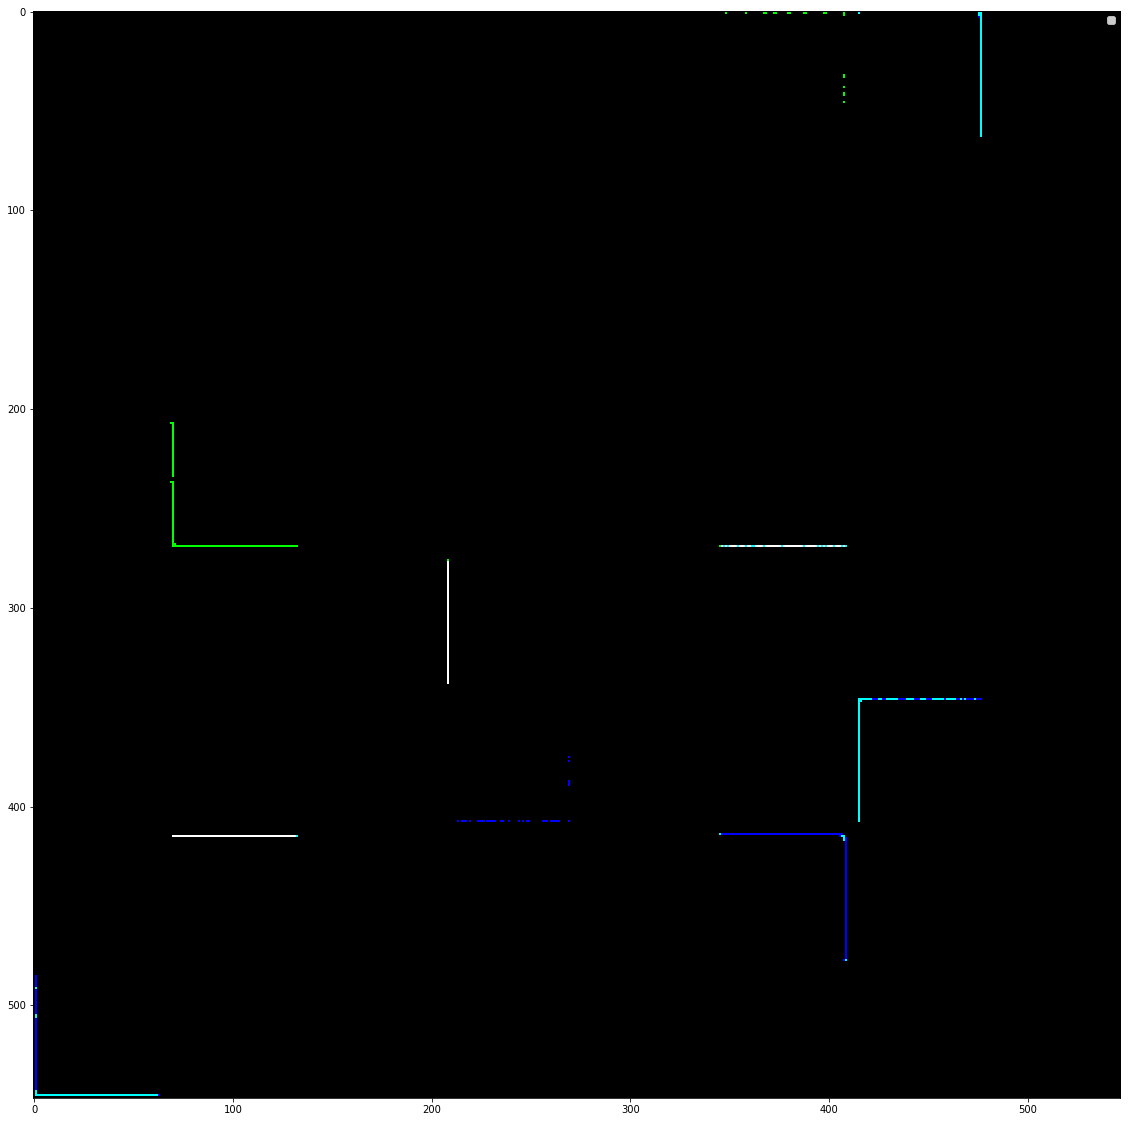

In [27]:
generate_in_one_layer_all_fillter(layer_name='block1_conv1')

No handles with labels found to put in legend.


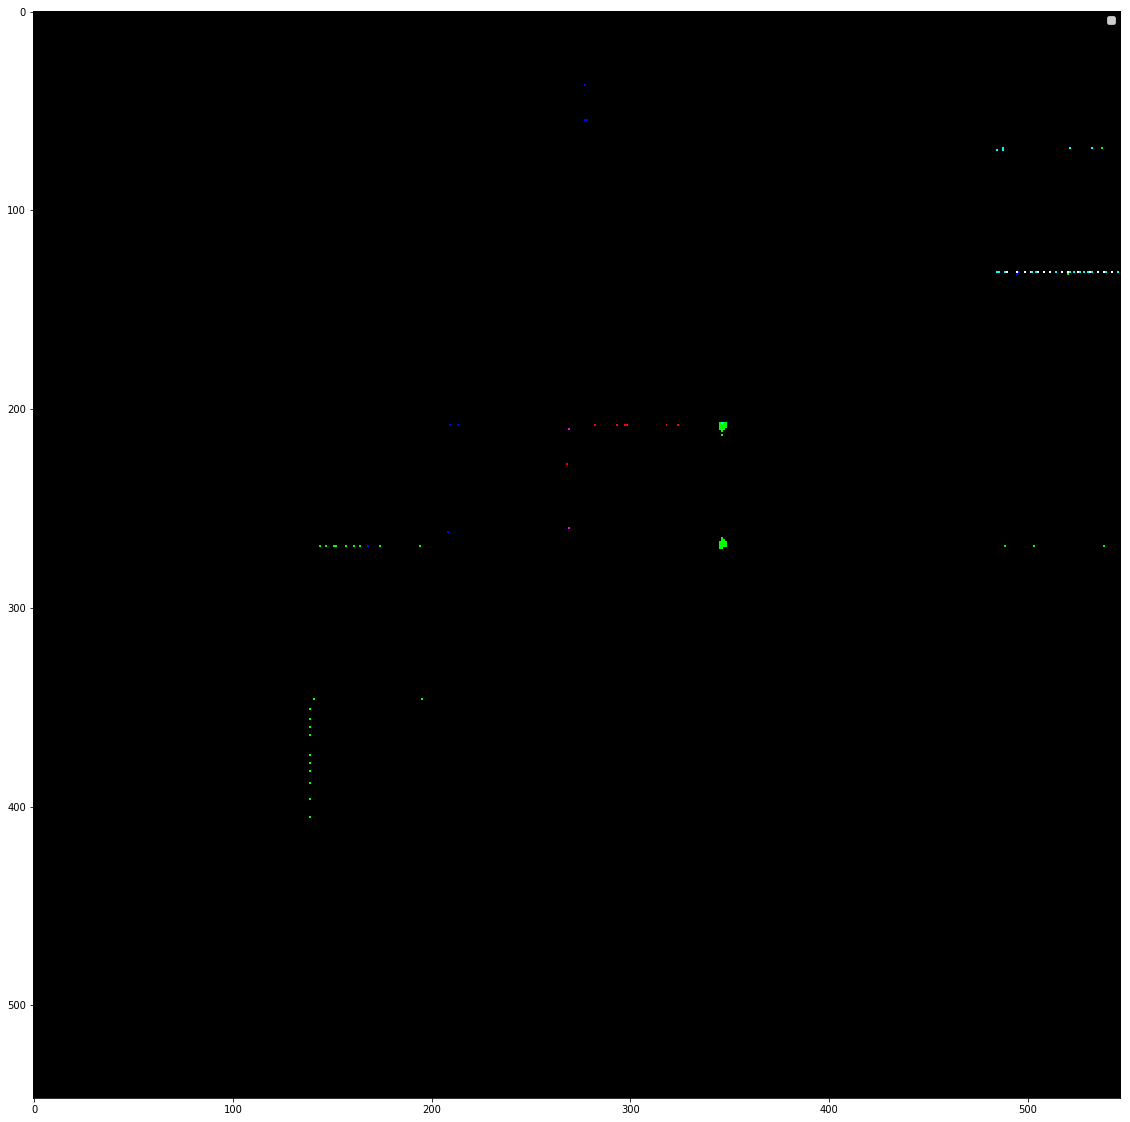

In [28]:
generate_in_one_layer_all_fillter(layer_name='block2_conv1')

No handles with labels found to put in legend.


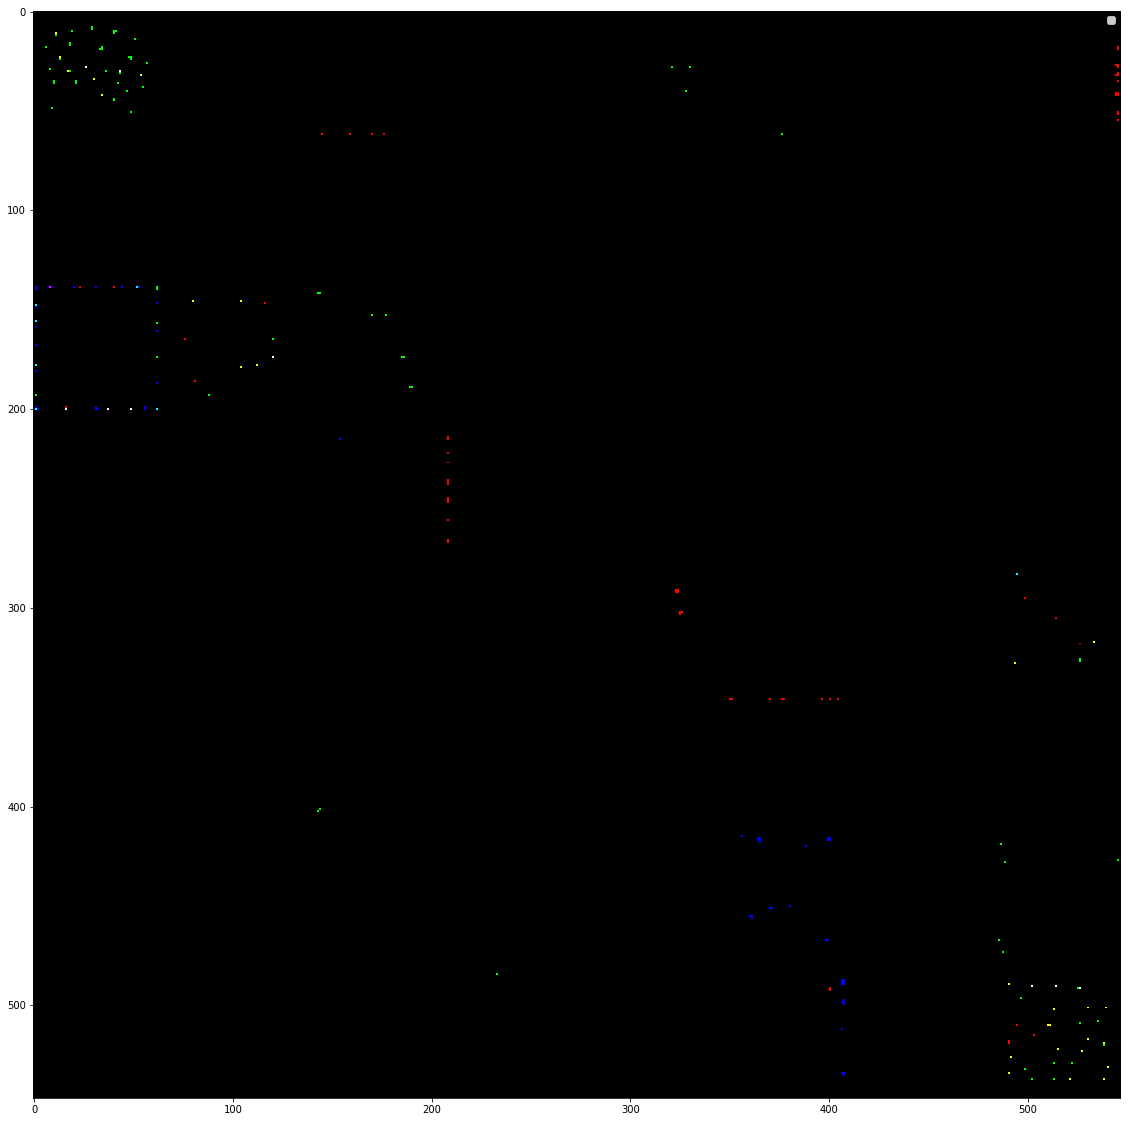

In [29]:
generate_in_one_layer_all_fillter(layer_name='block3_conv1')

No handles with labels found to put in legend.


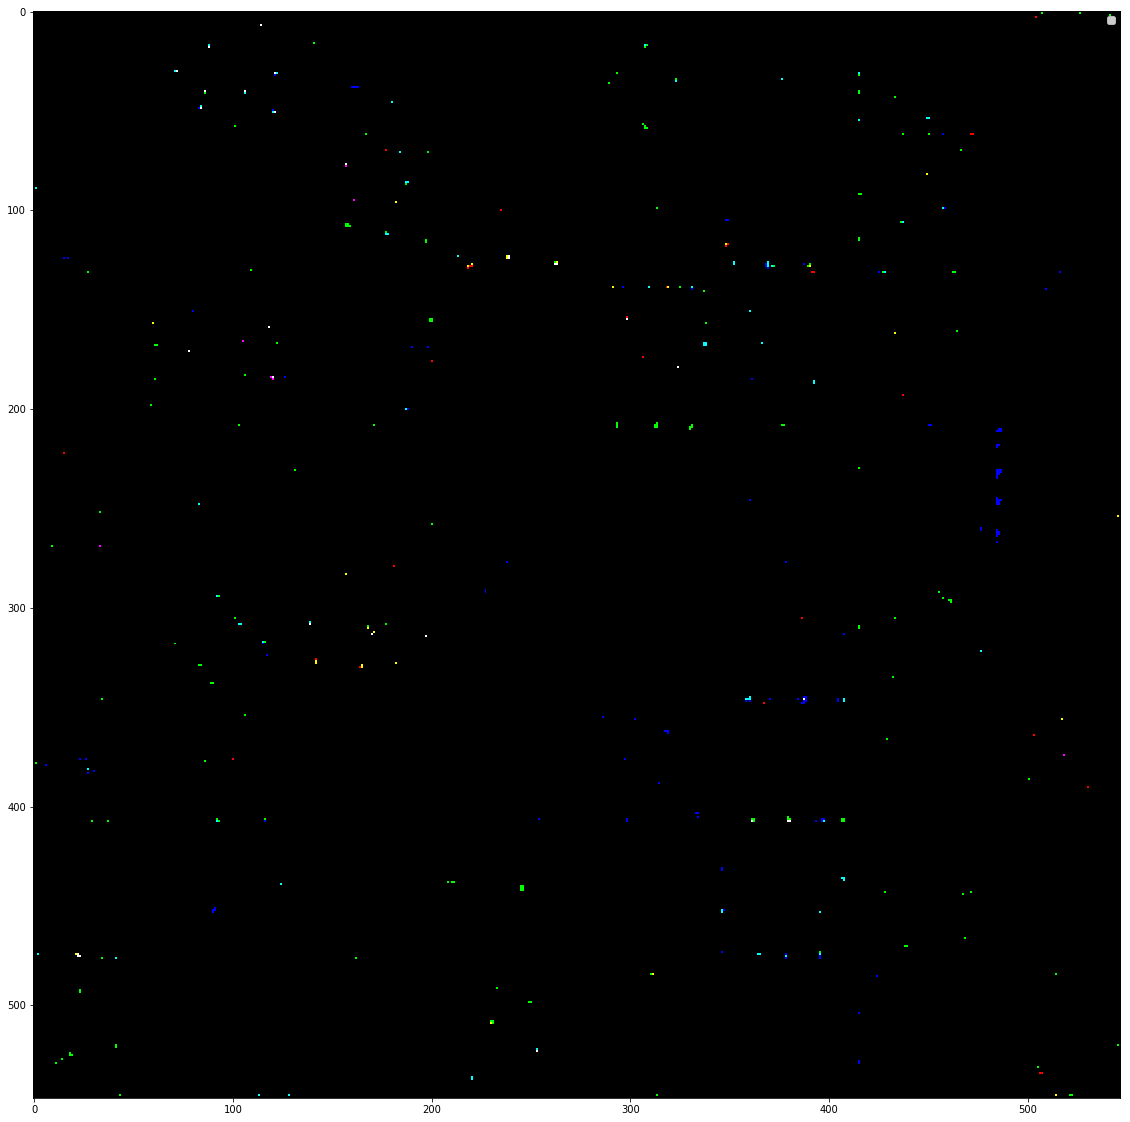

In [30]:
generate_in_one_layer_all_fillter(layer_name='block4_conv1')

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

No handles with labels found to put in legend.


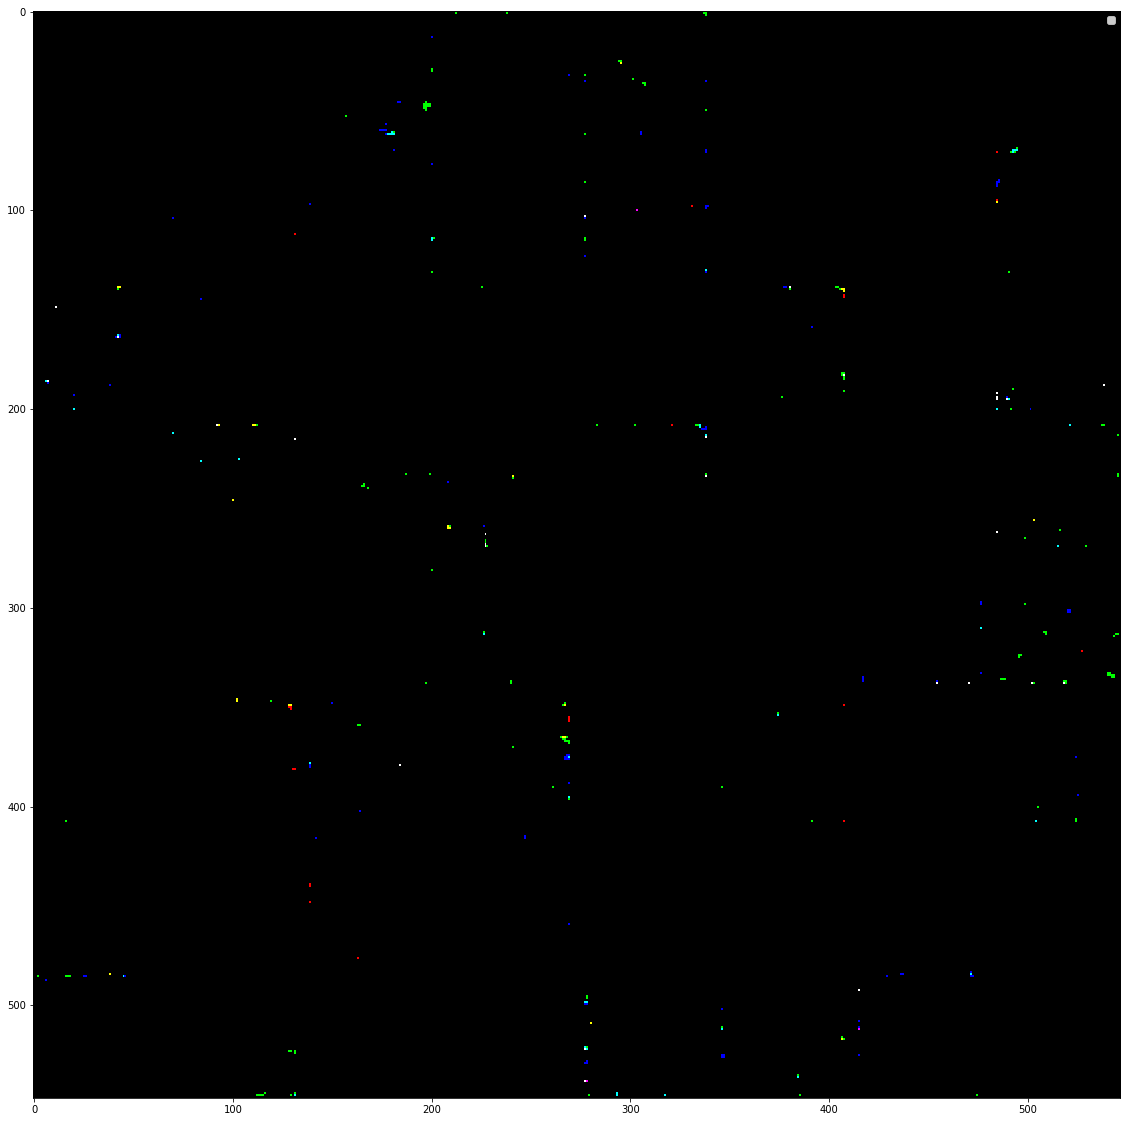

In [34]:
generate_in_one_layer_all_fillter(layer_name='block4_conv3')